<font size="+3"><strong>Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Import libraries here
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
import plotly.express as px

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [3]:
# Build your `wrangle` function
def wrangle (filepath):
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Mexico City", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    #Split lat-lon column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True)

    #Split lat-lon column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns = "place_with_parent_names", inplace = True)

    #Drop columns with more than 50% null values
    df.drop(columns = ["surface_total_in_m2", "price_usd_per_m2", "rooms",
                      "floor", "expenses"], inplace = True)

    #Drop low- and high- cardinality categorical variables
    df.drop(columns= ["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2'
    ],inplace = True)
    
    return df

In [4]:
# Use this cell to test the wrangle function on the file `mexico-city-real-estate-1.csv`
frame1 = wrangle("data/mexico-city-real-estate-1.csv")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 11 to 4605
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1101 non-null   int64  
 1   price_aprox_usd        1101 non-null   float64
 2   surface_covered_in_m2  1101 non-null   float64
 3   lat                    1041 non-null   float64
 4   lon                    1041 non-null   float64
 5   borough                1101 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 60.2+ KB
None


Unnamed: 0  price_aprox_usd  surface_covered_in_m2        lat         lon  \
11          12         94022.66                   57.0  23.634501 -102.552788   
20          21         70880.12                   56.0  19.402413  -99.095391   
21          22         68228.99                   80.0  19.357820  -99.149406   
22          23         24235.78                   60.0  19.504985  -99.208557   
26          27         94140.20                   50.0  19.354219  -99.126244   

          borough  
11  Benito Juárez  
20      Iztacalco  
21  Benito Juárez  
22   Azcapotzalco  
26       Coyoacán

In [5]:
frame1.isnull().sum()/len(frame1)

Unnamed: 0               0.000000
price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.054496
lon                      0.054496
borough                  0.000000
dtype: float64

In [6]:
frame1.select_dtypes("object").nunique()

borough    14
dtype: int64

In [7]:
sorted(frame1.columns)

['Unnamed: 0',
 'borough',
 'lat',
 'lon',
 'price_aprox_usd',
 'surface_covered_in_m2']

<Axes: >

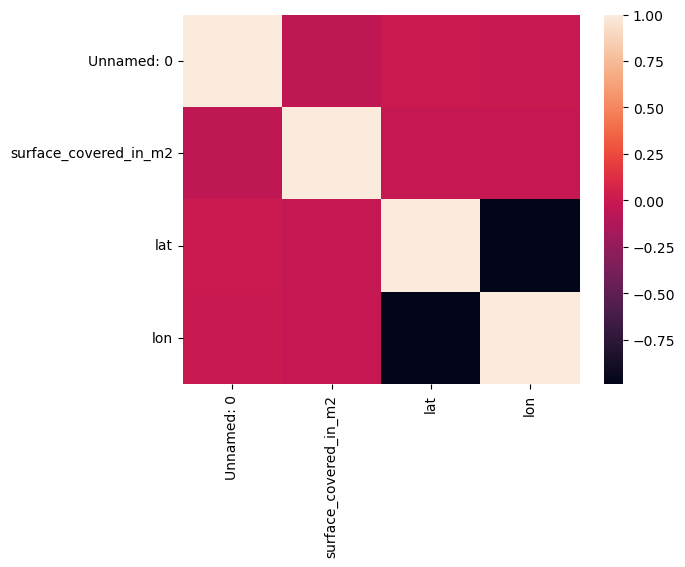

In [8]:
# Check for multicollinearlity
corr = frame1.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr)

In [9]:
# Extract data files
files = glob("data/mexico-city-real-estate-*.csv")
files.sort()
files

['data/mexico-city-real-estate-1.csv',
 'data/mexico-city-real-estate-2.csv',
 'data/mexico-city-real-estate-3.csv',
 'data/mexico-city-real-estate-4.csv',
 'data/mexico-city-real-estate-5.csv']

In [10]:
# Create datafromes
frames = [wrangle(file) for file in files]
frames[1]

Unnamed: 0  price_aprox_usd  surface_covered_in_m2        lat  \
0              1         63223.78                   88.0  19.516777   
1              2         25289.51                   48.0  19.466724   
17            18         89250.90                   90.0  19.383327   
19            20         39887.51                   60.0  19.388280   
20            21         42475.37                   80.0  19.454582   
...          ...              ...                    ...        ...   
4610        4611         83264.38                   54.0  19.458118   
4612        4613         60589.45                   65.0  23.634501   
4616        4617         94045.37                   65.0  19.472155   
4620        4621         58640.05                   80.0  19.295734   
4623        4624         38935.31                   76.0  23.634501   

             lon            borough  
0     -99.160149  Gustavo A. Madero  
1     -99.131614  Gustavo A. Madero  
17    -99.152712      Benito Juárez  
19    -99.195529     Álvaro Obregón  
20    -99.145651         Cuauhtémoc  
...          ...                ...  
4610  -99.125557         Cuauhtémoc  
4612 -102.552788         Cuauhtémoc  
4616  -99.161186       Azcapotzalco  
4620  -99.146996            Tlalpan  
4623 -102.552788         Cuauhtémoc  

[1100 rows x 6 columns]

In [11]:
# Combine the dataframes in frames into a single dataframe
df = pd.concat(frames, ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5473 non-null   int64  
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 256.7+ KB
None


Unnamed: 0  price_aprox_usd  surface_covered_in_m2        lat         lon  \
0          12         94022.66                   57.0  23.634501 -102.552788   
1          21         70880.12                   56.0  19.402413  -99.095391   
2          22         68228.99                   80.0  19.357820  -99.149406   
3          23         24235.78                   60.0  19.504985  -99.208557   
4          27         94140.20                   50.0  19.354219  -99.126244   

         borough  
0  Benito Juárez  
1      Iztacalco  
2  Benito Juárez  
3   Azcapotzalco  
4       Coyoacán

## Explore

Text(0.5, 1.0, 'Distribution of Apartment Prices')

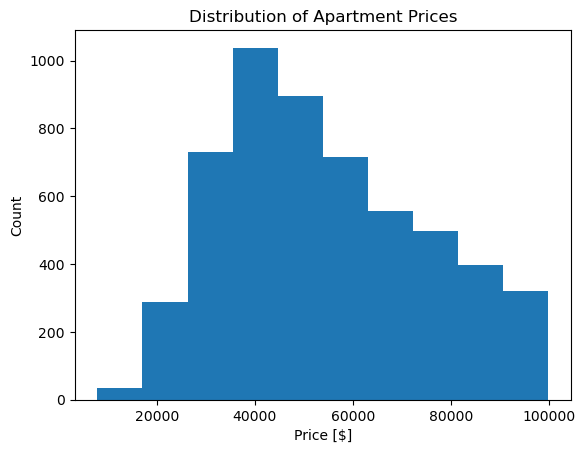

In [12]:
# Plot the histogram on price_aprox_usd

fig, ax = plt.subplots() 

ax.hist(df["price_aprox_usd"]) 

# Label axes using the axes 
ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")


# Add title 
ax.set_title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

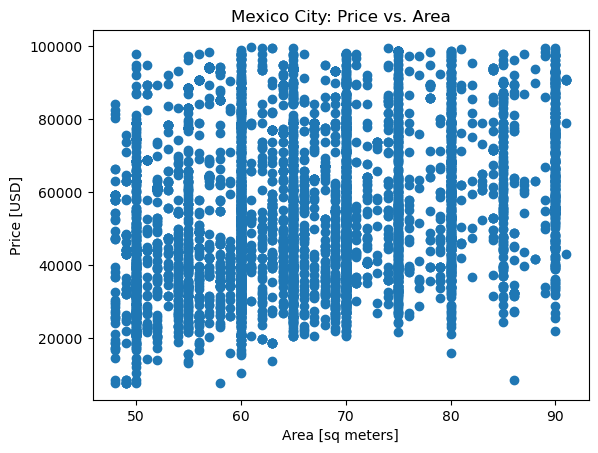

In [13]:
# Create the scatter plot on surface_covered_in_m2 and price_aprox_usd
fig, ax = plt.subplots() 

ax.scatter(x = df["surface_covered_in_m2"], y = df["price_aprox_usd"]) 

# Label axes 
ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")

#  Add title 
ax.set_title("Mexico City: Price vs. Area")

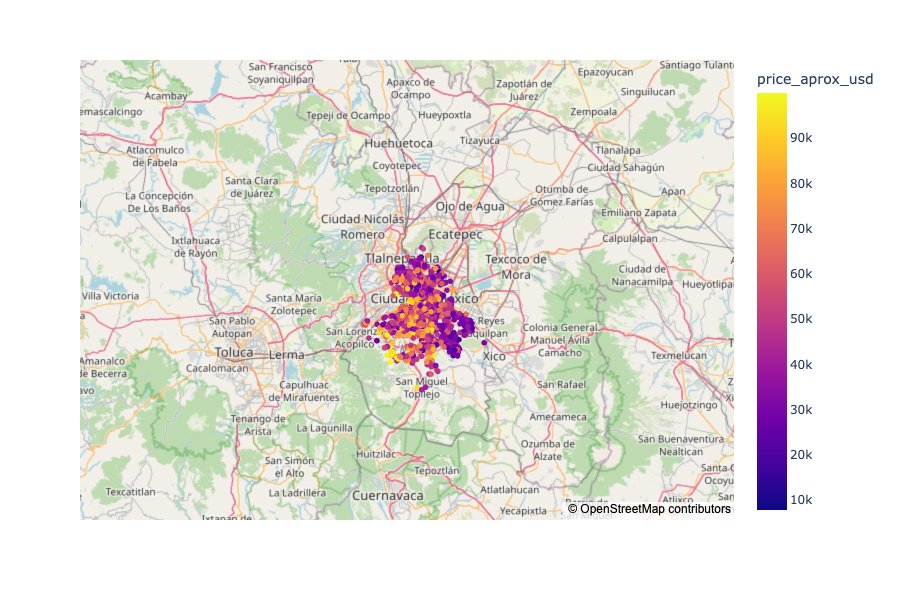

In [14]:
# Plot Mapbox location and price

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color= "price_aprox_usd",
    hover_data = ["price_aprox_usd"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

In [15]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
y_train = df[target]
X_train = df[features]

In [16]:
X_train.shape

(5473, 4)

In [17]:
y_train.shape

(5473,)

# Build Model

## Baseline

In [18]:
# Calculate the mean absolute error
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


## Iterate

In [19]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    Ridge()
)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [20]:
# Import test data
X_test = pd.read_csv("data/mexico-city-test-features.csv")
index = X_test.columns[0]  # Get the name of the first column
X_test.drop(columns=[index], inplace=True) 
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


surface_covered_in_m2        lat        lon        borough
0                     60  19.493185 -99.205755   Azcapotzalco
1                     55  19.307247 -99.166700       Coyoacán
2                     50  19.363469 -99.010141     Iztapalapa
3                     60  19.474655 -99.189277   Azcapotzalco
4                     74  19.394628 -99.143842  Benito Juárez

In [21]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

# Communicate Results

In [22]:
# Extract the coefficients
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp = pd.Series(feat_imp.values, index=feat_imp.index).reindex(feat_imp.abs().sort_values().index)
feat_imp

surface_covered_in_m2               291.654156
borough_Cuauhtémoc                 -350.531990
borough_Iztacalco                   405.403127
lat                                 478.901375
borough_Xochimilco                  929.857400
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
lon                               -2492.221814
borough_Álvaro Obregón             3275.121061
borough_Coyoacán                   3737.561001
borough_Venustiano Carranza       -5609.918629
borough_La Magdalena Contreras    -5925.666450
borough_Gustavo A. Madero         -6637.429757
borough_Cuajimalpa de Morelos      9157.269123
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Benito Juárez             13778.188880
borough_Tláhuac                  -14166.869486
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

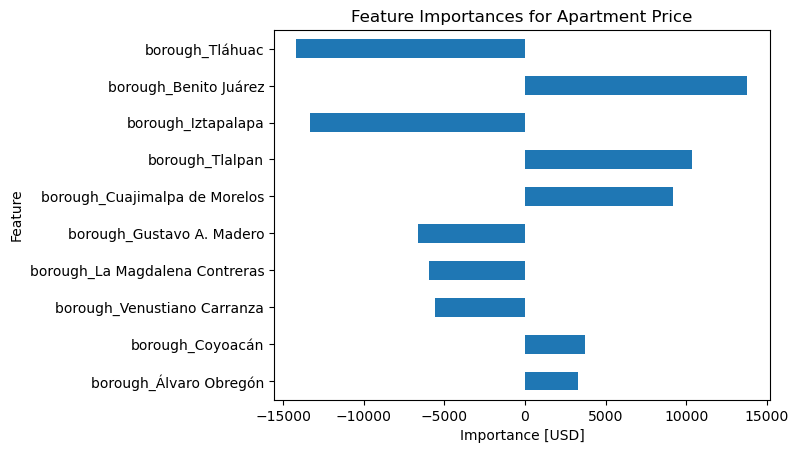

In [23]:
# Plot the 10 most influential coefficients
fig, ax = plt.subplots()

# Create the horizontal bar plot on the axes object
feat_imp.sort_values(key = abs).tail(10).plot(kind = "barh", ax = ax)

#feat_imp...plot(..., ax=ax)

#  Label axes 
ax.set_xlabel("Importance [USD]") 
ax.set_ylabel("Feature")

# Add title 
ax.set_title("Feature Importances for Apartment Price")

In [24]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [25]:
make_prediction(105, 19.60, -98.46, "Tlalpan")

'Predicted apartment price: $72715.51'

In [26]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

'Predicted apartment price: $55210.06'

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…